# Neural Predictivity

## Setup

### Install Necessary Packages

In [1]:
#pip install pytorch-lightning scikit-learn scipy lightly

### Import packages

In [2]:
import os
import torchvision
import PIL
import lightly
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import tqdm
import warnings
import logging
import sklearn
import h5py as hdf
from matplotlib import pyplot as plt
from torchvision.models import alexnet
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

In [3]:
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [4]:
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

### Load Neural Data

### Load Stimuli

In [5]:
class NaturalScenes(torch.utils.data.Dataset):
    def __init__(self,file_path = 'DeepMouseTrap/neural_data/brain_observatory/stimulus_set.npy'):
        self.ims = np.load(file_path)
        self.size = 118
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize([256]),torchvision.transforms.CenterCrop(224),torchvision.transforms.Resize([64,64]),torchvision.transforms.ToTensor()])
    def __len__(self):
        return self.size
    def __getitem__(self, index):
        im = PIL.Image.fromarray(self.ims[index])
        im = self.transform(im)
        im = im.unsqueeze(0)
        return im
stimulus = NaturalScenes()
train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

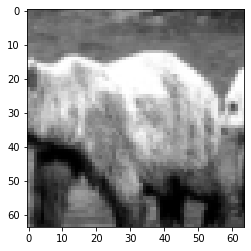

In [6]:
plt.imshow(torch.permute(torch.squeeze(stimulus[0]),(1,2,0)))
model = alexnet(pretrained=False)
model.features

### Define Necessary Functions

In [16]:
def extract_model_response(model=alexnet(pretrained=False), stimulus = train_stim):
    LAYER_MAPPING = {2:'conv1',5:'conv2',8:'conv3',10:'conv4',12:'conv5'}
    model_activations = {layer:None for layer in LAYER_MAPPING.values()}
    for ind,layer in LAYER_MAPPING.items():
        activation_model=model[:ind] #get activation model at layer
        activation_model.eval()
        activations = []
        for j in range(len(stimulus)):
            activation = activation_model(stimulus[j]) #extract activations
            activations.append(activation.detach().numpy().squeeze().flatten())
        activations = np.stack(activations)
        #print(activations.shape)
        model_activations[layer]=activations
    return model_activations

def extract_neural_response(layer, ims=train_stim.indices): #,test_ims=test_stim.indices):
    neural_responses = hdf.File('../datasets/VisualCoding/neuropixels/filtered_ephys.hdf5','r')
    VIS_responses = neural_responses[layer]
    per_specimen_response = {}
    for specimen in VIS_responses.keys():
        specimen_population = np.transpose(np.array(VIS_responses[specimen]),(1,0,2))#change to shape (num_ims,num_neurons,num_trials)
        per_specimen_response[specimen] = specimen_population[ims]
    return per_specimen_response

def spearman_brown(pearson_r):
    return (2*pearson_r)/(1+pearson_r)

def split_half(train,test):
    
    #train1,train2,test1,test2 = train_test_split(np.transpose(train,(2,0,1)), np.transpose(test,(2,0,1)),test_size=0.5) #split by trials
    
    train1 = np.transpose(train,(2,0,1))[np.arange(0,50,2)]
    train1 = np.mean(np.transpose(train1,(1,2,0)),axis=-1) 
    train2 = np.transpose(train,(2,0,1))[np.arange(1,50,2)]
    train2 = np.mean(np.transpose(train2,(1,2,0)),axis=-1)
    test1 = np.transpose(test,(2,0,1))[np.arange(0,50,2)]
    test1 = np.mean(np.transpose(test1,(1,2,0)),axis=-1)
    test2 = np.transpose(test,(2,0,1))[np.arange(1,50,2)]
    test2 = np.mean(np.transpose(test2,(1,2,0)),axis=-1)
    return (train1,train2), (test1,test2)

def inter_animal_consistency(model_activations_train, model_activations_test, specimen_response_train,specimen_response_test):
    
    # specimen_response_train_halves,specimen_response_test_halves = split_half(specimen_response_train,specimen_response_test)
    # specimen_response_train1,specimen_response_train2 = specimen_response_train_halves
    # specimen_response_test1,specimen_response_test2 = specimen_response_test_halves
    pls1 = PLSRegression(n_components=25)
    
    
    pls1.fit(model_activations_train,np.mean(specimen_response_train,axis=-1))
    predictions1 = pls1.predict(model_activations_test) #M(r^l_train,s^1_train)_test
    r,p = sp.stats.pearsonr(predictions1.flatten(),np.mean(specimen_response_test,axis=-1).flatten()) #Corr(M_1,s_2)
     
#     pls2 = PLSRegression(n_components=25)
#     pls2.fit(model_activations_train,specimen_response_train2)
#     predictions2 = pls2.predict(model_activations_test) #M(r_1^train,s^2_train)_test
    
#     mapping_r,mapping_p = sp.stats.pearsonr(predictions1.flatten(),predictions2.flatten())
#     mapping_sbr = spearman_brown(mapping_r)#Spearman Corr(M(r_l,s_1),M(r_1,s_2))
#     response_r,response_p = sp.stats.pearsonr(specimen_response_test1.flatten(),specimen_response_test2.flatten())
#     response_sbr = spearman_brown(response_r) #Spearman Corr(S_1,S_2)
#     denominator = np.sqrt(mapping_sbr * response_sbr)
    return r#/denominator
    
def layer_predictivity(layer_activations_train,layer_activations_test,vis_layer):
    specimen_response_train = extract_neural_response(vis_layer, train_stim.indices)
    specimen_response_test = extract_neural_response(vis_layer, test_stim.indices)
    inter_animal_consistencies = {specimen:None for specimen in specimen_response_train.keys()}
    for specimen in specimen_response_train.keys():
        inter_animal_consistencies[specimen] = inter_animal_consistency(layer_activations_train, layer_activations_test, specimen_response_train[specimen], specimen_response_test[specimen])
    return np.median(list(inter_animal_consistencies.values()))

def model_predictivity(model, vis_layer):
    model_activations_train = extract_model_response(model, train_stim)
    model_activations_test = extract_model_response(model, test_stim)
    layer_wise_predictivity = {layer:None for layer in model_activations_train.keys()}
    for layer in model_activations_train.keys():
        layer_activations_train = model_activations_train[layer]
        layer_activations_test = model_activations_test[layer]
        layer_wise_predictivity[layer] = layer_predictivity(layer_activations_train, layer_activations_test,vis_layer)
    return layer_wise_predictivity    

In [17]:
visp_responses_train = extract_neural_response('VISp')['732592105']
visp_responses_test = extract_neural_response('VISp',test_stim.indices)['732592105']
visp_responses_train,visp_responses_test=split_half(visp_responses_train,visp_responses_test)
visp_responses_train1,visp_responses_train2 = visp_responses_train
print(visp_responses_train[1]==visp_responses_test[0])

[[False False False ... False False False]
 [False False  True ... False False False]
 [False False False ... False False  True]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


### Load Model

In [18]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        AlexNet = alexnet()
        self.backbone = torch.nn.Sequential(*list(AlexNet.children())[:-1])
        #print(self.backbone)
        hidden_dim = 9216
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss(temperature=0.1)

    def forward(self, x):
        h= self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = LARS(params=self.parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-6)
        #scheduler = LinearWarmupCosineAnnealingLR(optimizer = optim,warmup_epochs=10,max_epochs=200)
        return [optim]#, [scheduler]
    
    def train_dataloader(self):
        collate_fn = lightly.data.SimCLRCollateFunction(input_size=64,gaussian_blur=0.0)
        return DataLoader(
                        lightly.data.LightlyDataset('../datasets/ImageNet64/train/'),
                        batch_size=512,
                        shuffle=True,
                        collate_fn=collate_fn,
                        drop_last=True,
                        num_workers=8,
                        pin_memory=False
                    )

## Calculate Neural Predictivities

### Contrastive

In [19]:
train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
print(train_stim.indices)
print(test_stim.indices)
test_model_contrastive = SimCLRModel().load_from_checkpoint('rep_data/temp/checkpoints/epoch199.ckpt')
neural_predictivities_contrastive = {'VISp':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISal':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISam':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISpm':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISrl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]}
                                    }
#test_model.backbone[0]

[40, 83, 58, 67, 12, 20, 36, 51, 3, 76, 15, 49, 104, 106, 62, 89, 44, 64, 69, 55, 109, 53, 28, 105, 97, 27, 80, 93, 63, 47, 14, 54, 103, 92, 95, 18, 90, 43, 11, 70, 68, 72, 46, 0, 33, 112, 82, 10, 59, 16, 84, 77, 19, 42, 86, 75, 50, 94, 8]
[26, 116, 107, 48, 71, 23, 57, 79, 88, 38, 60, 1, 5, 98, 100, 81, 115, 111, 102, 91, 31, 30, 17, 99, 24, 32, 37, 74, 41, 85, 114, 52, 117, 13, 25, 22, 35, 2, 78, 65, 108, 7, 21, 66, 61, 9, 96, 34, 113, 4, 110, 87, 56, 39, 101, 45, 73, 6, 29]


In [20]:
for i in range(1):
    if i <=1:
        print(i)
    train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
    for layer,predictivities in neural_predictivities_contrastive.items():
        if i <=1:
            print(layer)
        model_predictivities = model_predictivity(test_model_contrastive.backbone[0],layer)
        for l,p in model_predictivities.items():
            if i <= 1:
                print(f'{l}:{p}')
            predictivities[l].append(p)

0
VISp
conv1:0.859129874339944
conv2:0.8586700419416269
conv3:0.8726293957366353
conv4:0.8370685385231931
conv5:0.8181620972103643
VISl
conv1:0.8187319677003999
conv2:0.8132528962382397
conv3:0.8247253184656207
conv4:0.8024443973181343
conv5:0.766073693398821
VISal
conv1:0.8678767228433149
conv2:0.8647639381976078
conv3:0.8711336728412087
conv4:0.8523520705203194
conv5:0.8238764383262693
VISam
conv1:0.8839452729657544
conv2:0.86736699262945
conv3:0.880633715135509
conv4:0.8552789848179434
conv5:0.8302920079551941
VISpm
conv1:0.8337727008490114
conv2:0.830244773093591
conv3:0.8283742291098889
conv4:0.8024343513350567
conv5:0.7589063649985386
VISrl
conv1:0.8727287035862326
conv2:0.8388377158002701
conv3:0.8561636571765627
conv4:0.8074255156232514
conv5:0.7749638644720026


In [ ]:
for l,p in neural_predictivities_contrastive.items():
    neural_predictivities_contrastive[l] = pd.DataFrame.from_dict(p)

In [ ]:
# neural_predictivities_visl = model_predictivity(test_model.backbone[0],'VISl')

In [ ]:
# neural_predictivities_visal = model_predictivity(test_model.backbone[0], 'VISal')

In [ ]:
# neural_predictivities_visam = model_predictivity(test_model.backbone[0], 'VISam')

In [ ]:
# neural_predictivities_vispm = model_predictivity(test_model.backbone[0],'VISpm')

In [ ]:
# neural_predictivities_visrl = model_predictivity(test_model.backbone[0],'VISrl')

In [ ]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=neural_predictivities_contrastive['VISp'],ax=ax).set(title='VISP')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=neural_predictivities_contrastive['VISl'],ax=ax).set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=neural_predictivities_contrastive['VISal'],ax=ax).set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=neural_predictivities_contrastive['VISam'],ax=ax).set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=neural_predictivities_contrastive['VISpm'],ax=ax).set(title='VISPm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=neural_predictivities_contrastive['VISrl'],ax=ax).set(title='VISrl')
fig.suptitle("Neural Predictivity of Constrastive AlexNet Trained on ImageNet64")
fig.text(0.5, 0.04, 'Layer Depth', ha='center')
fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')

### Supervised

In [ ]:
train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
test_model_supervised = alexnet(pretrained=True)
neural_predictivities_supervised = {'VISp':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISal':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISam':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISpm':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISrl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]}
                                    }

In [ ]:
for i in range(1):
    print(i)
    train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
    for layer,predictivities in neural_predictivities_supervised.items():
        if i <=1:
            print(layer)
        model_predictivities = model_predictivity(test_model_supervised.features,layer)
        for l,p in model_predictivities.items():
            if i <= 1:
                print(f'{l}:{p}')
            predictivities[l].append(p)

In [ ]:
for l,p in neural_predictivities_supervised.items():
    neural_predictivities_supervised[l] = pd.DataFrame.from_dict(p)

In [ ]:
# neural_predictivities_visl_supervised = model_predictivity(test_model_supervised.features,'VISl')
# neural_predictivities_visl_supervised_df = pd.DataFrame.from_dict(neural_predictivities_visl_supervised.items(),orient='columns')

In [ ]:
neural_predictivities_supervised['VISp']

In [ ]:
pd.DataFrame(neural_predictivities_supervised['VISp'][1])

In [ ]:
# neural_predictivities_visal_supervised = model_predictivity(test_model_supervised.features, 'VISal')
# neural_predictivities_visal_supervised_df = pd.DataFrame.from_dict(neural_predictivities_visal_supervised.items(),orient='columns')

In [ ]:
# neural_predictivities_visam_supervised = model_predictivity(test_model_supervised.features, 'VISam')
# neural_predictivities_visam_supervised_df = pd.DataFrame.from_dict(neural_predictivities_visam_supervised.items(),orient='columns')

In [ ]:
# neural_predictivities_vispm_supervised = model_predictivity(test_model_supervised.features,'VISpm')
# neural_predictivities_vispm_supervised_df = pd.DataFrame.from_dict(neural_predictivities_vispm_supervised.items(),orient='columns')

In [ ]:
# neural_predictivities_vispm_supervised_df = pd.DataFrame.from_dict(neural_predictivities_vispm_supervised.items(),orient='columns')

In [ ]:
# neural_predictivities_visrl_supervised = model_predictivity(test_model_supervised.features,'VISrl')
# neural_predictivities_visrl_supervised_df = pd.DataFrame.from_dict(neural_predictivities_visrl_supervised.items(),orient='columns')

In [ ]:
# neural_predictivities_visrl_supervised_df

In [ ]:
neural_predictivities_supervised

In [ ]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=neural_predictivities_supervised['VISp']).set(title='VISP')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=neural_predictivities_supervised['VISl'],ax=ax).set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=neural_predictivities_supervised['VISal'],ax=ax).set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=neural_predictivities_supervised['VISam'],ax=ax).set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=neural_predictivities_supervised['VISpm'],ax=ax).set(title='VISPm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=neural_predictivities_supervised['VISrl'],ax=ax).set(title='VISrl')
fig.suptitle("Neural Predictivity of Supervised AlexNet Trained on ImageNet")
fig.text(0.5, 0.04, 'Layer Depth', ha='center')
fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')

In [ ]:

neural_predictivities = {layer:pd.concat([neural_predictivities_contrastive[layer].assign(objective='contrastive'),neural_predictivities_supervised[layer].assign(objective='supervised')]) for layer in neural_predictivities_contrastive.keys()}

In [ ]:
 pd.DataFrame.melt(neural_predictivities['VISp'],'objective')

### Untrained

#### Calculate VISP Neural Predictivity

In [ ]:
stimulus = NaturalScenes()
test_model_untrained = alexnet(pretrained = False)
neural_predictivities_untrained = {'VISp':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISal':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISam':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISpm':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]},
                                     'VISrl':{'conv1':[],'conv2':[],'conv3':[],'conv4':[],'conv5':[]}
                                    }

In [ ]:
for i in range(1):
    print(i)
    train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
    for layer,predictivities in neural_predictivities_untrained.items():
        if i <=1:
            print(layer)
        model_predictivities = model_predictivity(test_model_untrained.features,layer)
        for l,p in model_predictivities.items():
            if i <= 1:
                print(f'{l}:{p}')
            predictivities[l].append(p)

In [ ]:
for l,p in neural_predictivities_untrained.items():
    neural_predictivities_untrained[l] = pd.DataFrame.from_dict(p)

In [ ]:
neural_predictivities_untrained

#### Graph

In [ ]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=neural_predictivities_untrained['VISp'],ax=ax).set(title='VISp')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=neural_predictivities_untrained['VISl'],ax=ax).set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=neural_predictivities_untrained['VISal'],ax=ax).set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=neural_predictivities_untrained['VISam'],ax=ax).set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=neural_predictivities_untrained['VISam'],ax=ax).set(title='VISPm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=neural_predictivities_untrained['VISrl'],ax=ax).set(title='VISrl')
fig.suptitle("Neural Predictivity of Untrained AlexNet")
fig.text(0.5, 0.04, 'Layer Depth', ha='center')
fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')

In [ ]:
neural_predictivities = {layer:pd.concat([neural_predictivities_contrastive[layer].assign(objective='contrastive'),neural_predictivities_supervised[layer].assign(objective='supervised'), neural_predictivities_untrained[layer].assign(objective='untrained')]) for layer in neural_predictivities_contrastive.keys()}

In [ ]:
fig = plt.figure(facecolor="white",figsize=(10,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(3, 2, 1)
sns.pointplot(data=pd.melt(neural_predictivities['VISp'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISP')
ax = fig.add_subplot(3, 2, 2)
sns.pointplot(data=pd.melt(neural_predictivities['VISl'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISl')
ax = fig.add_subplot(3, 2, 3)
sns.pointplot(data=pd.melt(neural_predictivities['VISal'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISal')
ax = fig.add_subplot(3, 2, 4)
sns.pointplot(data=pd.melt(neural_predictivities['VISam'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISam')
ax = fig.add_subplot(3, 2, 5)
sns.pointplot(data=pd.melt(neural_predictivities['VISpm'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISpm')
ax = fig.add_subplot(3, 2, 6)
sns.pointplot(data=pd.melt(neural_predictivities['VISrl'],id_vars='objective',var_name='Layer Depth',value_name='Neural Predictivity'),x='Layer Depth',y='Neural Predictivity',hue='objective').set(title='VISrl')
fig.suptitle("Neural Predictivity of AlexNet Trained on ImageNet")
# fig.text(0.5, 0.04, 'Layer Depth', ha='center')
# fig.text(0.04, 0.5, 'Neural Predictivity', va='center', rotation='vertical')

In [ ]:
domain_preds = {'sketch':None,'infograph':None,'clipart':None,'quickdraw':None,'paint':None,'real':None}
logger = setup_logger('domain_preds', 'domains2.log', level=logging.INFO)
try:
    for domain in tqdm.notebook.tqdm(domain_preds.keys(),desc='Domains'):
        logger.info(f'Running experiment for {domain}') 
        stimulus = NaturalScenes()
        test_model_domain = SimCLRModel().load_from_checkpoint(f'rep_data/{domain}2/checkpoints/last.ckpt')
        neural_predictivities_domain = {'VISp':{f'conv{i}':[] for i in range(1, 6)},
                                        'VISl':{f'conv{i}':[] for i in range(1, 6)},
                                        'VISal':{f'conv{i}':[] for i in range(1, 6)},
                                        'VISam':{f'conv{i}':[] for i in range(1, 6)},
                                        'VISpm':{f'conv{i}':[] for i in range(1, 6)},
                                        'VISrl':{f'conv{i}':[] for i in range(1, 6)}
                                        }
        for i in tqdm.notebook.tqdm(range(100),desc="Iteration"):
            train_stim,test_stim = torch.utils.data.random_split(stimulus,[int(118/2),int(118/2)])
            for layer,predictivities in neural_predictivities_domain.items():
                model_predictivities = model_predictivity(test_model_domain.backbone[0],layer)
                for l,p in model_predictivities.items():
                    predictivities[l].append(p)
        logger.info(f'Experiment Complete. Results per Layer:')
        neural_predictivities_domain = {vis_layer:pd.DataFrame.from_dict(results) for vis_layer,results in neural_predictivities_domain.items()}
        for l,p in neural_predictivities_domain.items():
            logger.info(f'{l}')
            logger.info(f'{p.describe()}')
        domain_preds[domain]=neural_predictivities_domain
except Exception as e:
    logger.error(e)

In [ ]:
neural_preds_domain = {vis_layer:pd.concat([domain_preds[domain][vis_layer].assign(Domain=domain) for domain in domain_preds.keys()] + [neural_predictivities_contrastive[vis_layer].assign(Domain='ImageNet'), neural_predictivities_untrained[vis_layer].assign(Domain='Untrained')]) for vis_layer in domain_preds[domain].keys()}

In [ ]:
neural_preds_domain['VISp']

In [ ]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
#fig.subplots_adjust(hspace=0.3, wspace=0.1)
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISp'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[0,0])
plot.set(title='VISp',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',legend = False,
                     ax=axs[0,1])
plot.set(title='VISl',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISal'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[1,0])
plot.set(title='VISal',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISam'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[1,1])
plot.set(title='VISam',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISpm'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[2,0])
plot.set(title='VISpm',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(neural_preds_domain['VISrl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[2,1])
plot.set(title='VISrl',xlabel=None,ylabel=None)
plot.get_legend().remove()
fig.suptitle("Neural Predictivity of AlexNet Trained on various Domains")
fig.supxlabel('Layer Depth')
fig.supylabel('Neural Predictivity')
fig.tight_layout()
# labels_handles = {
#   label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
# }
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines[:8], labels[:8],loc='upper right',bbox_to_anchor=(1.15,1),title='Domains')
plt.show()

In [ ]:
neural_preds_domain_df = pd.concat([df.assign(vis_layer=visual_layer) for visual_layer,df in neural_preds_domain.items()])
neural_preds_domain_df

In [ ]:
fig,axs = plt.subplots(3,2,figsize=(17,10))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISp'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[0,0],
                   order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISp'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[0,0],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"], 
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISp',xlabel=None,ylabel=None)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[0,1],
                   order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[0,1],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISl',xlabel=None,ylabel=None)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISal'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[1,0],
                   order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISal'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[1,0],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISal',xlabel=None,ylabel=None)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISam'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[1,1],
                   order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISam'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[1,1],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISam',xlabel=None,ylabel=None)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISpm'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[2,0],
                   order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISpm'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[2,0],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISpm',xlabel=None,ylabel=None)
plot = sns.boxenplot(data=pd.melt(neural_preds_domain['VISrl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                   x='Domain',
                   y='Neural Predictivity',
                   ax=axs[2,1],
                   order=["real", "paint", "clipart", "sketch", "quickdraw", "infograph"])
# plot = sns.stripplot(data=pd.melt(neural_preds_domain['VISrl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
#                    x='Domain',
#                    y='Neural Predictivity',
#                    ax=axs[2,1],
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color = 'black',
#                    alpha = 0.1)
plot.set(title='VISrl',xlabel=None,ylabel=None)
fig.suptitle("Neural Predictivity of AlexNet Trained on various Domains")
fig.supxlabel('Domain')
fig.supylabel('Neural Predictivity')
# labels_handles = {
#   label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
# }
# handles, labels = ax.get_legend_handles_labels()
fig.tight_layout()
# fig.legend(handles,labels,)

In [ ]:
melted = pd.melt(neural_preds_domain_df,id_vars=['Domain','vis_layer'],var_name='layer_depth',value_name='Neural Predictivity')
sns.set(rc = {'figure.figsize':(10,10)})
plot = sns.boxenplot(data=melted,
                   x='Domain',
                   y='Neural Predictivity',
                   order=["ImageNet","real", "paint", "clipart", "sketch", "quickdraw", "infograph","Untrained"])
# plot = sns.stripplot(data=melted,
#                    x='Domain',
#                    y='Neural Predictivity',
#                    order=["ImageNet", "real", "paint", "clipart", "sketch", "quickdraw", "infograph", "Untrained"],
#                    color='black',
#                    alpha=0.1)
plot.set(title='Neural Predictivity of Contrastive AlexNet Trained on Various Domains')

In [ ]:
train_loss_ssl=[]
for domain in ['clipart','infograph2','paint','quickdraw2','sketch2','real','temp']:
        checkpoint = torch.load(f'rep_data/{domain}/checkpoints/last.ckpt',map_location=torch.device('cpu'))
        train_loss_ssl.append(list(checkpoint['callbacks'].values())[0]['current_score'].item())

In [ ]:
loss2median = {}
for domain,cp in zip(['clipart','infograph','paint','quickdraw','sketch','real','ImageNet'],['clipart','infograph2','paint','quickdraw2','sketch2','real','temp']):
    checkpoint = torch.load(f'rep_data/{cp}/checkpoints/last.ckpt',map_location=torch.device('cpu'))
    loss = list(checkpoint['callbacks'].values())[0]['current_score'].item()
    median = np.nanmedian(melted[melted['Domain']==domain]['Neural Predictivity'])
    loss2median[loss] = median
sns.scatterplot(x=loss2median.keys(),y=loss2median.values())
for domain, items in zip(['clipart','infograph','paint','quickdraw','sketch','real','ImageNet'],loss2median.items()):
    loss,pred = items
    plt.text(loss+0.01, pred+0.001, domain)

In [ ]:
extract_neural_response('VISp')[0][222420].shape

## Experimental